In [1]:
import numpy as np
import PIL
from PIL import Image
from PIL import ImageOps
from skimage import color
from skimage import io, transform
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
import re
from sklearn.metrics import confusion_matrix

#function to check file names since pneumonia dataset is composed of viral and bacterial pneumonia
def separate_pneumonia(file_list):
    bacteria_list = []
    virus_list = []
    #regular expressions to search for word in file name
    bacteria = re.compile(r"bacteria")
    virus = re.compile(r"virus")
    for file in file_list:
        if bacteria.search(file):
            bacteria_list.append(file)
        elif virus.search(file):
            virus_list.append(file)
    return bacteria_list,virus_list
    
#define the paths for all training, testing, and validation data, both normal and pneumonia images

test_normal_path = r"D:\Fall2019\CSCI547\chest_xray\test\NORMAL\\"
test_pneumonia_path = r"D:\Fall2019\CSCI547\chest_xray\test\PNEUMONIA\\"

test_files_normal= os.listdir(test_normal_path)
test_files_pneumonia = os.listdir(test_pneumonia_path)
test_files_pneumonia_bacteria, test_files_pneumonia_virus = separate_pneumonia(test_files_pneumonia)

train_normal_path = r"D:\Fall2019\CSCI547\chest_xray\train\NORMAL\\"
train_pneumonia_path = r"D:\Fall2019\CSCI547\chest_xray\train\PNEUMONIA\\"

train_files_normal = os.listdir(train_normal_path)
train_files_pneumonia = os.listdir(train_pneumonia_path)
train_files_pneumonia_bacteria, train_files_pneumonia_virus = separate_pneumonia(train_files_pneumonia)


val_normal_path = r"D:\Fall2019\CSCI547\chest_xray\val\NORMAL\\"
val_pneumonia_path = r"D:\Fall2019\CSCI547\chest_xray\val\PNEUMONIA\\"

val_files_normal = os.listdir(val_normal_path)
val_files_pneumonia = os.listdir(val_pneumonia_path)

#initialize lists where array of converted image will be stored. Lists for normal and pneumonia will be combined later

#consider initializing as an array
test_normal=[]
test_pneumonia_bacteria = []
test_pneumonia_virus = []

train_normal = []
train_pneumonia_bacteria = []
train_pneumonia_virus = []

val_normal = []
val_pneumonia = []

#new height and width for images since all images are different sizes 
new_width  = 50
new_height = 50
inputs = new_width*new_height
N = 2

def read_in_image(path, file_list, new_width, new_height,flattened = False):
    image_list = []
    for image in file_list:
        size = (new_width,new_height)
        image = color.rgb2gray(io.imread(path + image))
        image = transform.resize(image, size, mode='constant')
        if flattened:
            image = image.flatten()
        image_list.append(image)
    return image_list

test_normal = read_in_image(test_normal_path,test_files_normal,new_width,new_height) 
print('Done')
test_pneumonia_bacteria = read_in_image(test_pneumonia_path,test_files_pneumonia_bacteria,new_width,new_height)
print('Done')
test_pneumonia_virus = read_in_image(test_pneumonia_path,test_files_pneumonia_virus,new_width,new_height)
print('Done')

train_normal = read_in_image(train_normal_path,train_files_normal,new_width,new_height) 
print('Done')
train_pneumonia_bacteria = read_in_image(train_pneumonia_path,train_files_pneumonia_bacteria,new_width,new_height)
print('Done')
train_pneumonia_virus = read_in_image(train_pneumonia_path,train_files_pneumonia_virus,new_width,new_height)
print('Done')

val_normal = read_in_image(val_normal_path,val_files_normal,new_width,new_height) 
print('Done')
val_pneumonia = read_in_image(val_pneumonia_path,val_files_pneumonia,new_width,new_height)
print('Done')

Done
Done
Done
Done
Done
Done
Done
Done


In [108]:
#consolidate lists and create y labels: 0 for normal 1 for pneumonia or 0 for normal, 1 for bacteria and 2 for virus
#length of lists for making y labels
tb = len(test_pneumonia_bacteria)
tv = len(test_pneumonia_virus)
tn = len(test_normal)
trb = len(train_pneumonia_bacteria)
trv = len(train_pneumonia_virus)
trn = len(train_normal)

x_test = []
x_test.extend(test_normal)
x_test.extend(test_pneumonia_bacteria) 
x_test.extend(test_pneumonia_virus)
x_test = np.array(x_test)

#initialize lists for various y_test data
y_test_2class = []
y_test_3class = []

y_test_normal = [0]*tn
y_test_pneumonia_bacteria = [1]*tb
y_test_pneumonia_virus = [2]*tv
y_test_pneumonia2 = [1]*(tv+tb)

#y_test if we treat data with 2 classes
y_test_2class.extend(y_test_normal)
y_test_2class.extend(y_test_pneumonia2)
y_test_2class = np.array(y_test_2class)

#y_test if we treat data with 3 classes
y_test_3class.extend(y_test_normal)
y_test_3class.extend(y_test_pneumonia_bacteria)
y_test_3class.extend(y_test_pneumonia_virus)
y_test_3class = np.array(y_test_3class)

x_train = []
x_train.extend(train_normal)
x_train.extend(train_pneumonia_bacteria) #len of training set:5216
x_train.extend(train_pneumonia_virus)
x_train = np.array(x_train)

#initailize lists for y_train data
y_train_2class = []
y_train_3class = []

y_train_normal = [0]*trn
y_train_pneumonia_bacteria = [1]*trb
y_train_pneumonia_virus = [2]*trv
y_train_pneumonia2 = [1]*(trb+trv)

#y_train if we have 2 classes
y_train_2class.extend(y_train_normal)
y_train_2class.extend(y_train_pneumonia2)
y_train_2class = np.array(y_train_2class)

#y_train if we have 3 classes
y_train_3class.extend(y_train_normal)
y_train_3class.extend(y_train_pneumonia_bacteria)
y_train_3class.extend(y_train_pneumonia_virus)
y_train_3class = np.array(y_train_3class)

x_val = []
x_val.extend(val_normal)
x_val.extend(val_pneumonia)
x_val = np.array(x_val)

y_val = []
y_val_normal = [0]*len(val_normal)
y_val_pneumonia = [1]*len(val_pneumonia)
y_val.extend(y_val_normal)
y_val.extend(y_val_pneumonia)
y_val = np.array(y_val)

In [107]:
print(len(train_normal),len(train_pneumonia_bacteria),len(train_pneumonia_virus))
len(x_test)
print(len(y_test_3class),len(y_test_2class))
print(np.unique(y_test_3class))
print(np.unique(y_test_2class))

1341 2530 1345
624 624
[0 1 2]
[0 1]


In [109]:
#cast data to tensors and reshape data for cnn, cnn expects channels, we only have 1
x_train = torch.from_numpy(x_train)
x_test = torch.from_numpy(x_test)
y_train_2class = torch.from_numpy(y_train_2class)
y_train_3class = torch.from_numpy(y_train_3class)
y_test_2class = torch.from_numpy(y_test_2class) 
y_test_3class = torch.from_numpy(y_test_3class) 
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val)

x_train = x_train.to(torch.float32)
x_train_channels = x_train.reshape(-1,1,2500)
x_test = x_test.to(torch.float32)
x_test_channels = x_test.reshape(-1,1,2500)
y_train_2class = y_train_2class.to(torch.long)
y_train_3class = y_train_3class.to(torch.long)
y_test_2class = y_test_2class.to(torch.long)
y_test_3class = y_test_3class.to(torch.long)

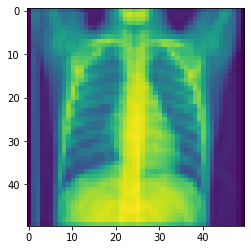

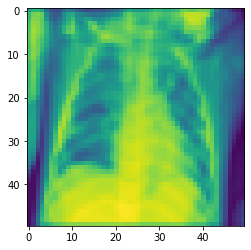

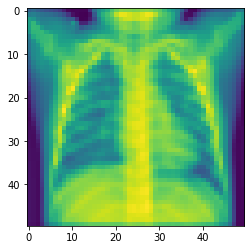

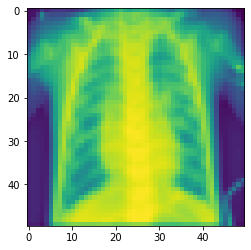

In [6]:
#what the images look like scaled down
plt.imshow(test_normal[100].reshape(50,50))
plt.show()
plt.imshow(test_pneumonia_bacteria[100].reshape(50,50))
plt.show()
plt.imshow(train_normal[100].reshape(50,50))
plt.show()
plt.imshow(train_pneumonia_virus[100].reshape(50,50))
plt.show()


**1D Convolutional Neural Network**

In [110]:
#cnn for 2 class data
class Net(nn.Module):
    def __init__(self):       
        super(Net,self).__init__()
        # Conv1d arguments: number of input feature maps, number of output feature maps, kernel width, edge padding
        self.conv1 = nn.Conv1d(1,32,2,padding=1) #takes one input and outputs 64 features, kernel width of 8 takes moving
                                                #average, padding adds zeros to the boundary
        # MaxPool1d arguments: kernel width, edge padding
        self.pool1 = nn.MaxPool1d(2,padding=1)
        
        self.conv2 = nn.Conv1d(32,16,2,padding=1)
        self.pool2 = nn.MaxPool1d(2,padding=1)
        
#         self.conv3 = nn.Conv1d(64,32,2,padding=2)
#         self.pool3 = nn.MaxPool1d(2,padding=0)
        
#         self.conv4 = nn.Conv1d(32,16,2,padding=0)
#         self.pool4 = nn.MaxPool1d(2,padding=0)
        
        self.l1 = nn.Linear(10032,300) #300 size of hidden layers
        self.l2 = nn.Linear(300,50)
        self.l3 = nn.Linear(50,2) # 2 outputs for 2 different classes (normal,pneumonia)
        
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.   """
        
        # Apply convolution
        a1 = self.conv1(x)
        
        # Apply activation function
        z1 = torch.relu(a1)
        
        # Apply max pooling
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)
        
#         a3 = self.conv3(z2)
#         z3 = torch.relu(a3)
#         z3 = self.pool3(z3)
        
#         a4 = self.conv4(z3)
#         z4 = torch.relu(a4)
#         z4 = self.pool4(z4)        
        
        # Flatten the array (basically removes singleton dimension)
        z_flat = self.dropout_1(torch.reshape(z2,(-1,10032))) #second argument of reshape has to match linear input
        
        # Apply linear transformation
        a5 = self.l1(z_flat)
        z5 = self.dropout_2(torch.relu(a5)) #applying dropout        
        
        a6 = self.l2(z5)
        z6 = self.dropout_3(torch.relu(a6))
        
        a7 = self.l3(z6)      
        
        return a7

In [111]:
#create train and test loaders for 2 and 3 class data
training_data_2class = TensorDataset(x_train_channels,y_train_2class)
test_data_2class = TensorDataset(x_test_channels,y_test_2class)
training_data_3class = TensorDataset(x_train_channels,y_train_3class)
test_data_3class = TensorDataset(x_test_channels,y_test_3class)


batch_size = 32
train_loader_2class = torch.utils.data.DataLoader(dataset=training_data_2class,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 32
test_loader_2class = torch.utils.data.DataLoader(dataset=test_data_2class,
                                           batch_size=batch_size, 
                                           shuffle=False)
batch_size = 32
train_loader_3class = torch.utils.data.DataLoader(dataset=training_data_3class,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 32
test_loader_3class = torch.utils.data.DataLoader(dataset=test_data_3class,
                                           batch_size=batch_size, 
                                           shuffle=False)

In [112]:
#below will train a model and compare accuracies for data for 2 class data
model_2class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.SGD(model_2class.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model_2class.parameters())

train_accs_2class = []
test_accs_2class = []

epochs = 50
# Loop over the data
for epoch in range(epochs):
    model_2class.train()
    # Loop over each subset of data
    for d,t in train_loader_2class:
        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()        
        # Make a prediction based on the model
        outputs = model_2class(d)        
        # Compute the loss
        loss = criterion(outputs,t)
        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model_2class.eval()
    total_2class=0.
    correct_2class=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_2class += float(t.size(0))
        correct_2class += float((predicted==t).sum())
    total_train_2class = 0
    correct_train_2class = 0
    for d,t in train_loader_2class:
        outputs = model_2class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_2class += float(t.size(0))
        correct_train_2class += float((predicted==t).sum())
    
    # Print the epoch, the training loss, and the test set accuracy.
    train_accs_2class.append(100.*correct_train_2class/total_train_2class)
    test_accs_2class.append(100.*correct_2class/total_2class)
    
    print(epoch,loss.item(),train_accs_2class[-1],test_accs_2class[-1])


0 0.6093010902404785 74.29064417177914 62.5
1 0.1817118227481842 94.57438650306749 79.48717948717949
2 0.14347022771835327 94.55521472392638 74.19871794871794
3 0.07623670995235443 95.5329754601227 76.92307692307692
4 0.19620580971240997 95.76303680981596 80.76923076923077
5 0.13464467227458954 95.9739263803681 76.4423076923077


KeyboardInterrupt: 

In [114]:
#neural net for 3 class data
class Net(nn.Module):
    def __init__(self):       
        super(Net,self).__init__()
        # Conv1d arguments: number of input feature maps, number of output feature maps, kernel width, edge padding
        self.conv1 = nn.Conv1d(1,32,2,padding=1) #takes one input and outputs 64 features, kernel width of 8 takes moving
                                                #average, padding adds zeros to the boundary
        # MaxPool1d arguments: kernel width, edge padding
        self.pool1 = nn.MaxPool1d(2,padding=1)
        
        self.conv2 = nn.Conv1d(32,16,2,padding=1)
        self.pool2 = nn.MaxPool1d(2,padding=1)
        
#         self.conv3 = nn.Conv1d(64,32,2,padding=2)
#         self.pool3 = nn.MaxPool1d(2,padding=0)
        
#         self.conv4 = nn.Conv1d(32,16,2,padding=0)
#         self.pool4 = nn.MaxPool1d(2,padding=0)
        
        self.l1 = nn.Linear(10032,300) #300 size of hidden layers
        self.l2 = nn.Linear(300,50)
        self.l3 = nn.Linear(50,3) # 3 outputs for 3 different classes (normal,bacteria,virus)
        
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.   """
        
        # Apply convolution
        a1 = self.conv1(x)
        
        # Apply activation function
        z1 = torch.relu(a1)
        
        # Apply max pooling
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)
        
#         a3 = self.conv3(z2)
#         z3 = torch.relu(a3)
#         z3 = self.pool3(z3)
        
#         a4 = self.conv4(z3)
#         z4 = torch.relu(a4)
#         z4 = self.pool4(z4)        
        
        # Flatten the array (basically removes singleton dimension)
        z_flat = self.dropout_1(torch.reshape(z2,(-1,10032))) #second argument of reshape has to match linear input
        
        # Apply linear transformation
        a5 = self.l1(z_flat)
        z5 = self.dropout_2(torch.relu(a5)) #applying dropout        
        
        a6 = self.l2(z5)
        z6 = self.dropout_3(torch.relu(a6))
        
        a7 = self.l3(z6)      
        
        return a7

In [115]:
#model to train for 3 class data
model_3class = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.SGD(model_3class.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model_3class.parameters())

train_accs_3class = []
test_accs_3class = []

epochs = 50
# Loop over the data
for epoch in range(epochs):
    model_3class.train()
    # Loop over each subset of data 
    for d,t in train_loader_3class:
        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()        
        # Make a prediction based on the model
        outputs = model_3class(d)        
        # Compute the loss
        loss = criterion(outputs,t)
        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model_3class.eval()
    total_3class=0.
    correct_3class=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_3class += float(t.size(0))
        correct_3class += float((predicted==t).sum())
    total_train_3class = 0
    correct_train_3class = 0
    for d,t in train_loader_3class:
        outputs = model_3class(d)
        _, predicted = torch.max(outputs.data,1)
        total_train_3class += float(t.size(0))
        correct_train_3class += float((predicted==t).sum())
    #Print the epoch, the training loss, and the test set accuracy.
    train_accs_3class.append(100.*correct_train_3class/total_train_3class)
    test_accs_3class.append(100.*correct_3class/total_3class)
    
    print(epoch,loss.item(),train_accs_3class[-1],test_accs_3class[-1])


0 0.715377688407898 61.82898773006135 47.916666666666664
1 0.6840709447860718 71.79831288343559 57.05128205128205
2 0.7761914134025574 76.49539877300613 65.7051282051282


KeyboardInterrupt: 

In [116]:
#Confusion matrix for 2 classes
y_pred_2class = np.argmax(model_2class(x_test_channels).cpu().detach(),axis=1)
y_test_cpu_2class = y_test_2class.cpu()

cm1 = confusion_matrix(y_pred_2class,y_test_cpu_2class)
#accuracy1 = np.sum(np.diag(cm1))/(tn+tb+tv)
precision1 = np.diag(cm1)/cm1.sum(axis=1)
recall1 = np.diag(cm1)/cm1.sum(axis=0)
#print('accuracy:', accuracy1)
print('precision:',precision1)
print('recall:',recall1)
print(cm1)

#confusion matrix for 3 classes
y_pred_3class = np.argmax(model_3class(x_test_channels).cpu().detach(),axis=1)
y_test_cpu_3class = y_test_3class.cpu()

cm2 = confusion_matrix(y_pred_3class,y_test_cpu_3class)
#accuracy2 = np.sum(np.diag(cm2))/(tn+tn+tv)
precision2 = np.diag(cm2)/cm2.sum(axis=1)
recall2 = np.diag(cm2)/cm2.sum(axis=0)
#print('accuracy:', accuracy1)
print('precision:',precision2)
print('recall:',recall2)
print(cm2)

#plots for training and testing accuracy for 2 and 3 class compared
plt.plot(train_accs_2class,label='Training accuracy 2 Class')
plt.plot(test_accs_2class,label='Test accuracy 2 Class')
plt.plot(train_accs_3class,label='Training accuracy 3 Class')
plt.plot(test_accs_3class,label='Test accuracy 3 Class')
plt.show()

NameError: name 'model_2class' is not defined

**2D Convolutional Neural Network**

In [ ]:
class Net(nn.Module):
    def __init__(self):       
        super(Net,self).__init__()
        # Conv1d arguments: number of input feature maps, number of output feature maps, kernel width, edge padding
        self.conv1 = nn.Conv2d(1,32,2,padding=1) #takes one input and outputs 64 features, kernel width of 8 takes moving
                                                #average, padding adds zeros to the boundary
        # MaxPool1d arguments: kernel width, edge padding
        self.pool1 = nn.MaxPool2d(2,padding=1)
        
        self.conv2 = nn.Conv2d(32,16,2,padding=1)
        self.pool2 = nn.MaxPool2d(2,padding=1)
        
#         self.conv3 = nn.Conv1d(64,32,2,padding=2)
#         self.pool3 = nn.MaxPool1d(2,padding=0)
        
#         self.conv4 = nn.Conv1d(32,16,2,padding=0)
#         self.pool4 = nn.MaxPool1d(2,padding=0)
        
        self.l1 = nn.Linear(10032,300) #300 size of hidden layers
        self.l2 = nn.Linear(300,50)
        self.l3 = nn.Linear(50,3) # 3 outputs for 3 different classes (normal,bacteria,virus)
        
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.dropout_3 = nn.Dropout(p=0.2)
    
    def forward(self,x):
        """
        This method runs the feedforward neural network.   """
        
        # Apply convolution
        a1 = self.conv1(x)
        
        # Apply activation function
        z1 = torch.relu(a1)
        
        # Apply max pooling
        z1 = self.pool1(z1)
                
        a2 = self.conv2(z1)
        z2 = torch.relu(a2)
        z2 = self.pool2(z2)
        
#         a3 = self.conv3(z2)
#         z3 = torch.relu(a3)
#         z3 = self.pool3(z3)
        
#         a4 = self.conv4(z3)
#         z4 = torch.relu(a4)
#         z4 = self.pool4(z4)        
        
        # Flatten the array (basically removes singleton dimension)
        z_flat = self.dropout_1(torch.reshape(z2,(-1,10032))) #second argument of reshape has to match linear input
        
        # Apply linear transformation
        a5 = self.l1(z_flat)
        z5 = self.dropout_2(torch.relu(a5)) #applying dropout        
        
        a6 = self.l2(z5)
        z6 = self.dropout_3(torch.relu(a6))
        
        a7 = self.l3(z6)      
        
        return a7

In [120]:
model_2class_2d = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

#optimizer = torch.optim.SGD(model_2class_2d.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(model_2class_2d.parameters())

train_accs = []
test_accs = []

epochs = 50
# Loop over the data
for epoch in range(epochs):
    model.train()
    # Loop over each subset of data
    for d,t in train_loader_2class:
        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()        
        # Make a prediction based on the model
        outputs = model_2class_2d(d)        
        # Compute the loss
        loss = criterion(outputs,t) 
        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model_2class_2d.eval()
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader_2class:
        outputs = model_2class_2d(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
    total_train = 0
    correct_train = 0
    for d,t in train_loader_2class:
        outputs = model(d)
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())

    # Print the epoch, the training loss, and the test set accuracy.
    train_accs.append(100.*correct_train/total_train)
    test_accs.append(100.*correct/total)

    print(epoch,loss.item(),train_accs[-1],test_accs[-1])
    
plt.plot(train_accs,label='Training accuracy')
plt.plot(test_accs,label='Test accuracy')
plt.show()

0 0.11955729871988297 94.44018404907976 79.96794871794872
1 0.07340019941329956 94.95782208588957 76.92307692307692
2 0.04239751398563385 94.6127300613497 77.24358974358974
3 0.035033635795116425 94.82361963190183 73.71794871794872
4 0.2196495234966278 94.670245398773 79.48717948717949
5 0.02671421691775322 94.59355828220859 76.76282051282051
6 0.08371765911579132 94.59355828220859 76.28205128205128
7 0.15999837219715118 94.28680981595092 75.64102564102564


KeyboardInterrupt: 

**Fully Connected Neural Network with Dropout**

In [121]:
class Net(nn.Module):
    def __init__(self):      
        super(Net,self).__init__()
        self.l1 = nn.Linear(2500,1500) #2500 inputs (number of pixels in image)
        self.l2 = nn.Linear(1500,1000) 
        self.l3 = nn.Linear(1000,750)
        self.l4 = nn.Linear(750,50)
        self.l5 = nn.Linear(50,3)
        self.l6 = nn.Linear(3,100)
        self.l7 = nn.Linear(100,500)
        self.l8 = nn.Linear(500,75)
        self.l9 = nn.Linear(75,3)
        
        self.dropout_1 = nn.Dropout(p=0.2)
        self.dropout_2 = nn.Dropout(p=0.2)
        self.dropout_3 = nn.Dropout(p=0.5)
        self.dropout_4 = nn.Dropout(p=0.5)
        self.dropout_5 = nn.Dropout(p=0.5)
        self.dropout_6 = nn.Dropout(p=0.5)
        self.dropout_7 = nn.Dropout(p=0.2)
        self.dropout_8 = nn.Dropout(p=0.2)

        
    def forward(self,x):  
        a1 = self.l1(x)
        z1 = self.dropout_1(torch.relu(a1))
        
        a2 = self.l2(z1)
        z2 = self.dropout_2(torch.relu(a2))
        
        a3 = self.l3(z2)
        z3 = self.dropout_3(torch.relu(a3))
        
        a4 = self.l4(z3)
        z4 = self.dropout_4(torch.relu(a4))
        
        a5 = self.l5(z4)
        z5 = self.dropout_5(torch.relu(a5))
        
        a6 = self.l6(z5)
        z6 = self.dropout_6(torch.relu(a6))
        
        a7 = self.l7(z6)
        z7 = self.dropout_7(torch.relu(a7))
        
        a8 = self.l8(z7)
        z8 = self.dropout_8(torch.relu(a8))
        
        a9 = self.l9(z8)
        
        return a9

In [122]:
#reshape data for fully connected nn, we no longer expect channels but features
x_train = x_train.reshape(-1,2500)
x_test = x_test.reshape(-1,2500)

In [123]:
training_data = TensorDataset(x_train,y_train_2class)
test_data = TensorDataset(x_test,y_test_2class)

batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=batch_size, 
                                           shuffle=True)

batch_size = 64
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=batch_size, 
                                           shuffle=False)

0 0.6400144696235657 74.29064417177914 62.5
1 0.3762378394603729 74.29064417177914 62.5
2 0.42240384221076965 94.03757668711657 77.72435897435898
3 0.27455997467041016 94.01840490797547 81.08974358974359
4 0.21623636782169342 94.47852760736197 79.48717948717949
5 0.31662625074386597 95.03450920245399 77.56410256410257
6 0.2664928138256073 95.01533742331289 77.88461538461539
7 0.3097166121006012 94.88113496932516 79.16666666666667
8 0.1863304227590561 95.5329754601227 75.80128205128206
9 0.3294070363044739 95.5138036809816 76.6025641025641
10 0.22849442064762115 95.32208588957056 78.2051282051282
11 0.21551786363124847 95.66717791411043 74.83974358974359
12 0.24910594522953033 94.78527607361963 79.48717948717949
13 0.27219706773757935 94.57438650306749 79.96794871794872
14 0.16940130293369293 95.74386503067484 77.40384615384616
15 0.30255165696144104 93.51993865030674 81.08974358974359
16 0.31685641407966614 95.70552147239263 77.08333333333333
17 0.2540532946586609 94.76610429447852 80.

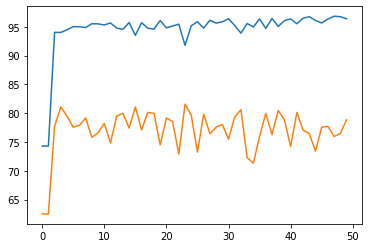

In [124]:
model2 = Net()
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.Adam(model2.parameters(),lr = .0002)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.8)

train_accs = []
test_accs = []
test_predictions = []
train_predictions =[]
epochs = 50
# Loop over the data
for epoch in range(epochs):
    model2.train()
    # Loop over each subset of data
    for d,t in train_loader:
        #t = t.unsqueeze(1)

        # Zero out the optimizer's gradient buffer
        optimizer.zero_grad()
        
        # Make a prediction based on the model
        outputs = model2(d)
       
        # Compute the loss
        loss = criterion(outputs,t)   

        # Use backpropagation to compute the derivative of the loss with respect to the parameters
        loss.backward()
        
        # Use the derivative information to update the parameters
        optimizer.step()
        
    model2.eval()
    total=0.
    correct=0.
    # Loop over all the test examples and accumulate the number of correct results in each batch
    for d,t in test_loader:
        outputs = model2(d)
        _, predicted = torch.max(outputs.data,1)
        total += float(t.size(0))
        correct += float((predicted==t).sum())
    total_train = 0
    correct_train = 0
    for d,t in train_loader:
        outputs = model2(d)
        _, predicted = torch.max(outputs.data,1)
        total_train += float(t.size(0))
        correct_train += float((predicted==t).sum())

    # Print the epoch, the training loss, and the test set accuracy.
    train_accs.append(100.*correct_train/total_train)
    test_accs.append(100.*correct/total)

    print(epoch,loss.item(),train_accs[-1],test_accs[-1])
    
plt.plot(train_accs,label='Training accuracy')
plt.plot(test_accs,label='Test accuracy')
plt.show()

In [126]:
#confusion matrix
y_pred2 = np.argmax(model2(x_test).cpu().detach(),axis=1)
y_test_cpu = y_test_2class.cpu()

cm2 = confusion_matrix(y_pred2,y_test_cpu)
accuracy2 = np.sum(np.diag(cm2))/(tn+tb+tv)
precision2 = np.diag(cm2)/cm2.sum(axis=1)
recall2 = np.diag(cm2)/cm2.sum(axis=0)
#print('accuracy:', accuracy2)
print('precision:',precision2)
print('recall:',recall2)
print(cm2)


precision: [0.91803279 0.75697211]
recall: [0.47863248 0.97435897]
[[112  10]
 [122 380]]
